<a href="https://colab.research.google.com/github/CHAMS1110/NLP/blob/main/Prediction_of_death_rate_for_the_next_100_year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Required Libraries for numerical analysis and prediction of stock prices


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math

# 2. Importing the Numerical dataset and performing Exploratory Analysis

In [109]:
# Dataframe for exploratory analysis
df=pd.read_csv('number-of-deaths-per-year.csv')
df.head()

,Year,Deaths
0,1950,48788536
1,1951,48514550
2,1952,47646612
3,1953,47499084
4,1954,47002804


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    151 non-null    int64
 1   Deaths  151 non-null    int64
dtypes: int64(2)
memory usage: 2.5 KB


In [111]:
fig = px.line(df, x = 'Year', y = 'Deaths', title='Death rate per year')
#fig1 = px.line(df, x = 'Year', y = 'Estimated', title='Death rate per year')
fig.show()
#fig1.show()

#3. Creating a dataframe for storing the Closing stock data per year

In [112]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [113]:
df2 = pd.read_csv('number-of-deaths-per-year.csv', usecols=[1], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

#4. Data Normalization and Division into Training and Test sets

In [114]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.50)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [115]:
# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

#5. Creating a LSTM Neural Network Model for Numerical Analysis

In [116]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(7, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)

Epoch 1/100
15/15 - 2s - loss: 0.0056 - 2s/epoch - 102ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0035 - 47ms/epoch - 3ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0031 - 47ms/epoch - 3ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0031 - 46ms/epoch - 3ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0029 - 50ms/epoch - 3ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0028 - 48ms/epoch - 3ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0027 - 53ms/epoch - 4ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0025 - 49ms/epoch - 3ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0025 - 47ms/epoch - 3ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0023 - 49ms/epoch - 3ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0022 - 58ms/epoch - 4ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0021 - 51ms/epoch - 3ms/step
Epoch 13/100
15/15 - 0s - loss: 0.0020 - 50ms/epoch - 3ms/step
Epoch 14/100
15/15 - 0s - loss: 0.0019 - 47ms/epoch - 3ms/step
Epoch 15/100
15/15 - 0s - loss: 0.0018 - 47ms/epoch - 3ms/step
Epoch 16/100
15/15 - 0s - loss: 0.0017 - 48ms/epoch - 3ms/step
E

In [117]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

3/3 [==============================] - 0s 4ms/step


#6. Making Predictions of the Model

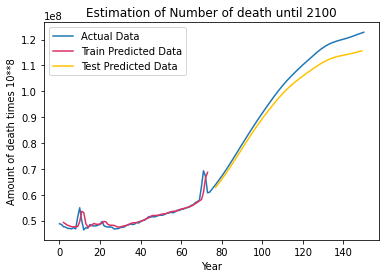

In [120]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2), label = 'Actual Data')
plt.title('Estimation of Number of death until 2100')
plt.xlabel('Year')
plt.ylabel('Amount of death times 10**8')
plt.plot(trainPredictPlot,color='#DE3163', label = 'Train Predicted Data')
plt.plot(testPredictPlot, color='#FFC300', label = 'Test Predicted Data')
plt.legend(loc='best')
plt.show()